In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical

D:\Anaconda3\envs\ProjetSemestre\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Anaconda3\envs\ProjetSemestre\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Anaconda3\envs\ProjetSemestre\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Anaconda3\envs\ProjetSemestre\lib\site-packages\tensorflow\python\framework\dty

### Data loading

The loading is designed for csv file generated by the Collect Information option of the ImageJ plugin. If the class of the nuclei is not missing, the entire file will have the same class.

In [2]:
CLASS_COLUMN = "Class"

OUTLIERS_EXCLUDED = False

def get_data(path, class_cat):
    df = pd.read_csv(path)
    del df["Label"]
    if OUTLIERS_EXCLUDED:
        df = df[((df-df.mean()).abs() < 3 * df.std()).all(axis=1)] #Remove outliers 99.9%
    if not(CLASS_COLUMN in df.columns.values):
        df.insert(0, CLASS_COLUMN, class_cat)
    return df

mouse_path = "../../data/measurements/mouse features.csv"
human_path = "../../data/measurements/human features.csv"

mouse = get_data(mouse_path, "Mouse")
human = get_data(human_path, "Human")

dataset = pd.concat([mouse, human], ignore_index=True)

classes = ["Mouse", "Human"]

headers = dataset.columns.values

for i, header in enumerate(headers):
    print(str(i) + " " + header)

0 Class
1 Nucleus minor Axis
2 Nucleus major Axis
3 Nucleus elongation
4 Cell minor Axis
5 Cell major Axis
6 Cell elongation
7 Nucleus area
8 Cell area
9 Area ratio
10 Direct neighbours mean distance
11 Direct neighbours variance distance
12 Lateral neighbours alignment
13 Lateral neighbours orientation differences
14 Lateral neighbours mean distance
15 Cells number in chain
16 Cells chain non reciprocal neighbours
17 Cells chain non reciprocal neighbours ratio
18 Cells chain tortuosity
19 Nucleus mean value channel 1
20 Nucleus variance value channel 1
21 Nucleus mean value channel 2
22 Nucleus variance value channel 2
23 Nucleus mean value channel 3
24 Nucleus variance value channel 3
25 Nucleus angular second moment
26 Nucleus contrast
27 Nucleus correlation
28 Nucleus sum of squares: variance
29 Nucleus inverse difference moment
30 Nucleus sum average
31 Nucleus sum variance
32 Nucleus sum entropy
33 Nucleus entropy
34 Nucleus difference variance
35 Nucleus difference entropy
36 Nu

In [3]:
dataset[CLASS_COLUMN].value_counts()

Mouse    38843
Human    26320
Name: Class, dtype: int64

### Data processing
Shuffle, normalize and split the data between inputs and targets.

In [4]:
#take the same number of values for each class, to take everything set -1
nb_values_per_class = dataset[CLASS_COLUMN].value_counts().min()

mapping = {CLASS_COLUMN: {}}

for i, class_name in enumerate(classes):
    mapping[CLASS_COLUMN][class_name] = i

shuffled_dataset = dataset.replace(mapping).sample(frac=1)
shuffled_dataset = shuffled_dataset.dropna()

#Normalize
mean_values = shuffled_dataset.mean().values
std_values = shuffled_dataset.std().values
for i, column in enumerate(headers[1:]):
    shuffled_dataset[column] = (shuffled_dataset[column] - mean_values[i + 1]) / std_values[i + 1]

if nb_values_per_class != -1:
    cur_dataset = pd.DataFrame(columns=headers)
    for i, class_name in enumerate(classes):
        shuffled_class = shuffled_dataset.where(shuffled_dataset[CLASS_COLUMN] == i).dropna()[:nb_values_per_class]
        cur_dataset = cur_dataset.append(shuffled_class, ignore_index=True)
    shuffled_dataset = cur_dataset.sample(frac=1)

inputs = shuffled_dataset.iloc[:, 1:].values
targets = shuffled_dataset.iloc[:, 0].values
targets = to_categorical(targets)

In [5]:
shuffled_dataset

,Class,Nucleus minor Axis,Nucleus major Axis,Nucleus elongation,Cell minor Axis,Cell major Axis,Cell elongation,Nucleus area,Cell area,Area ratio,...,Variance cytoplasm sum of squares: variance up to 40 connected neighbours,Variance cytoplasm inverse difference moment up to 40 connected neighbours,Variance cytoplasm sum average up to 40 connected neighbours,Variance cytoplasm sum variance up to 40 connected neighbours,Variance cytoplasm sum entropy up to 40 connected neighbours,Variance cytoplasm entropy up to 40 connected neighbours,Variance cytoplasm difference variance up to 40 connected neighbours,Variance cytoplasm difference entropy up to 40 connected neighbours,Variance cytoplasm information measures correlation 1 up to 40 connected neighbours,Variance cytoplasm information measures correlation 2 up to 40 connected neighbours
39091,1.0,0.480196,1.983622,1.093281,-0.773991,1.295542,1.635097,1.718300,0.147918,-1.297318,...,-0.285114,-0.468716,-0.517563,-0.534288,-0.408787,-0.456235,-0.181896,-0.408448,-0.495311,-0.375826
24484,0.0,-0.770190,-0.824023,-0.221828,-0.292629,-0.564258,-0.301936,-0.953261,-0.574460,0.494216,...,1.844552,2.409667,-0.322770,-0.182639,-0.404928,-0.439301,-0.179090,-0.326479,-0.493582,-0.226134
11451,0.0,-1.029546,-0.274473,0.550815,0.224713,-0.233658,-0.429095,-0.790644,0.015651,1.036538,...,-0.217791,0.806653,-0.456877,-0.433336,-0.408438,-0.328714,-0.156549,-0.358686,-0.380657,-0.272914
22362,0.0,0.161473,-1.636808,-1.512694,-1.836552,-1.698536,0.121239,-1.046185,-1.876775,-1.321543,...,-0.152514,-0.467302,1.806793,1.495729,0.680530,1.265343,-0.065496,-0.238438,1.384127,2.618962
33364,1.0,0.511160,-0.831035,-1.059379,0.310613,-0.558495,-0.706023,-0.302794,-0.177661,0.036844,...,-0.285114,-0.468716,-0.517563,-0.534288,-0.408787,-0.456235,-0.181896,-0.408448,-0.495311,-0.375826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22399,0.0,-0.015773,-0.251100,-0.284129,1.251618,0.327487,-0.681649,-0.186639,1.114479,1.349204,...,-0.285114,-0.468716,-0.517563,-0.534288,-0.408787,-0.456235,-0.181896,-0.408448,-0.495311,-0.375826
12834,0.0,0.094205,-0.238537,-0.349559,-0.942224,-0.781200,0.066323,-0.116946,-1.042480,-1.139531,...,-0.285114,-0.468716,-0.517563,-0.534288,-0.408787,-0.456235,-0.181896,-0.408448,-0.495311,-0.375826
23302,0.0,0.279993,1.509740,0.899860,1.319365,-0.034698,-0.928624,1.230450,0.717680,-0.571046,...,0.659704,0.334409,-0.197378,-0.235858,-0.361739,-0.313589,0.141547,0.161976,-0.383941,-0.213970
51010,1.0,-0.791438,-0.656908,-0.045090,-0.566535,-0.403338,0.042830,-0.860337,-0.574460,0.334491,...,-0.281603,-0.326801,-0.509256,-0.517333,-0.377783,-0.386002,-0.153637,0.338281,-0.484026,-0.373319


CSBDeep need 3D images with more than 1 element in each dimension, we create an image of size (2, 2, feature_size / 4). If the feature size is not a multiple of 4, it will be padded with 0.

In [6]:
def pad(features, target_size):
    result = np.zeros((features.shape[0], target_size))
    result[:features.shape[0],:features.shape[1]] = features
    return result

num_features = inputs.shape[1]

target_size = int(np.ceil(num_features/4) * 4)

inputs = pad(inputs, target_size)
inputs = inputs.reshape((-1, 2, 2, int(target_size/4)))

### Model creation

Any model accepted by tensorflow can be used as long as it have the expected input and ouput.

In [7]:
def get_model(reshape_included = True):
    dropout = 0.5
    model = keras.Sequential()
    if reshape_included:
        model.add(keras.layers.Reshape((target_size,), input_shape=(2, 2, int(target_size/4))))
    model.add(keras.layers.Dense(128, input_shape=(target_size,)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())
    model.add(keras.layers.Dropout(dropout))
    model.add(keras.layers.Dense(64))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())
    model.add(keras.layers.Dropout(dropout))
    model.add(keras.layers.Dense(32))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())
    model.add(keras.layers.Dropout(dropout))
    model.add(keras.layers.Dense(16))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())
    model.add(keras.layers.Dropout(dropout))
    model.add(keras.layers.Dense(2))
    model.add(keras.layers.Activation("softmax"))
    
    return model

optimizer = keras.optimizers.Adam()
loss_function = 'categorical_crossentropy'
              
demo_model = get_model()
demo_model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])
demo_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 484)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               62080     
_________________________________________________________________
batch_normalization_v1 (Batc (None, 128)               512       
_________________________________________________________________
re_lu (ReLU)                 (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)      

### Cross validation 

In [8]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

def evaluate(model, inputs, targets):
    prob_targets = model.predict(inputs, verbose=0)
    estimated_targets = model.predict_classes(inputs, verbose=0)
    
    estimated_targets = to_categorical(estimated_targets)
    
    accuracy = accuracy_score(targets, estimated_targets)
    precision = precision_score(targets, estimated_targets, average=None)
    recall = recall_score(targets, estimated_targets, average=None)
    f1 = f1_score(targets, estimated_targets, average=None)
    auc = roc_auc_score(targets, prob_targets, average=None)

    targets = targets.argmax(1)
    estimated_targets = estimated_targets.argmax(1)

    cm = confusion_matrix(targets, estimated_targets)
    cm = cm / cm.sum(axis=1)
    
    return accuracy, precision, recall, f1, auc, cm

In [9]:
from sklearn.model_selection import KFold

num_folds = 4
batch_size = 128
epochs = 100
validation_split = 0.2
verbose = 1

best_acc = 0

acc_per_fold = []

kfold = KFold(n_splits=num_folds, shuffle=False)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):

    model = get_model()
    model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history = model.fit(inputs[train], targets[train], validation_split=validation_split, epochs=epochs, batch_size=batch_size, verbose=verbose)

    metrics = evaluate(model, inputs[test], targets[test])
    acc = metrics[0]
    print(f'Score for fold {fold_no}: Accuracy of {acc*100}%')
    acc_per_fold.append(acc * 100)

    if(acc > best_acc):
        best_acc = acc
        best_metrics = metrics
        best_model = model
        best_model_history = history

    fold_no = fold_no + 1

    print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print('------------------------------------------------------------------------')

history = best_model_history
model = best_model

------------------------------------------------------------------------
Training for fold 1 ...
Train on 31584 samples, validate on 7896 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
31584/31584 [==============================] - 7s 237us/sample - loss: 0.5341 - acc: 0.7380 - val_loss: 0.2526 - val_acc: 0.8993
Epoch 2/100
31584/31584 [==============================] - 2s 72us/sample - loss: 0.3001 - acc: 0.8919 - val_loss: 0.1788 - val_acc: 0.9292
Epoch 3/100
31584/31584 [==============================] - 2s 60us/sample - loss: 0.2411 - acc: 0.9184 - val_loss: 0.1550 - val_acc: 0.9391
Epoch 4/100
31584/31584 [==============================] - 2s 60us/sample - loss: 0.2166 - acc: 0.9264 - val_loss: 0.1457 - val_acc: 0.9407
Epoch 5/100
31584/31584 [==============================] - 2s 58us/sample - loss: 0.1913 - acc: 0.9367 - val_loss: 0.1344 - val_acc: 0.9453
Epoch 6/100
31584/31584 [==============================] - 2s 59us/sample - loss: 0.1866 - acc: 0.9372 - 

31584/31584 [==============================] - 2s 64us/sample - loss: 0.1472 - acc: 0.9480 - val_loss: 0.1185 - val_acc: 0.9514
Epoch 13/100
31584/31584 [==============================] - 2s 64us/sample - loss: 0.1481 - acc: 0.9484 - val_loss: 0.1168 - val_acc: 0.9540
Epoch 14/100
31584/31584 [==============================] - 2s 65us/sample - loss: 0.1436 - acc: 0.9488 - val_loss: 0.1156 - val_acc: 0.9561
Epoch 15/100
31584/31584 [==============================] - 2s 65us/sample - loss: 0.1403 - acc: 0.9502 - val_loss: 0.1139 - val_acc: 0.9548
Epoch 16/100
31584/31584 [==============================] - 2s 65us/sample - loss: 0.1385 - acc: 0.9516 - val_loss: 0.1133 - val_acc: 0.9558
Epoch 17/100
31584/31584 [==============================] - 2s 66us/sample - loss: 0.1392 - acc: 0.9518 - val_loss: 0.1173 - val_acc: 0.9544
Epoch 18/100
31584/31584 [==============================] - 2s 65us/sample - loss: 0.1344 - acc: 0.9518 - val_loss: 0.1128 - val_acc: 0.9544
Epoch 19/100
31584/31584 [

31584/31584 [==============================] - 2s 66us/sample - loss: 0.1173 - acc: 0.9589 - val_loss: 0.1076 - val_acc: 0.9574
Epoch 27/100
31584/31584 [==============================] - 2s 65us/sample - loss: 0.1161 - acc: 0.9591 - val_loss: 0.1085 - val_acc: 0.9559
Epoch 28/100
31584/31584 [==============================] - 2s 65us/sample - loss: 0.1175 - acc: 0.9599 - val_loss: 0.1117 - val_acc: 0.9562
Epoch 29/100
31584/31584 [==============================] - 2s 65us/sample - loss: 0.1178 - acc: 0.9577 - val_loss: 0.1118 - val_acc: 0.9561
Epoch 30/100
31584/31584 [==============================] - 2s 66us/sample - loss: 0.1135 - acc: 0.9590 - val_loss: 0.1095 - val_acc: 0.9569
Epoch 31/100
31584/31584 [==============================] - 2s 65us/sample - loss: 0.1110 - acc: 0.9602 - val_loss: 0.1097 - val_acc: 0.9572
Epoch 32/100
31584/31584 [==============================] - 2s 65us/sample - loss: 0.1078 - acc: 0.9615 - val_loss: 0.1129 - val_acc: 0.9531
Epoch 33/100
31584/31584 [

31584/31584 [==============================] - 2s 67us/sample - loss: 0.1037 - acc: 0.9630 - val_loss: 0.0991 - val_acc: 0.9623
Epoch 41/100
31584/31584 [==============================] - 2s 67us/sample - loss: 0.1092 - acc: 0.9613 - val_loss: 0.0932 - val_acc: 0.9616
Epoch 42/100
31584/31584 [==============================] - 2s 68us/sample - loss: 0.1049 - acc: 0.9628 - val_loss: 0.0989 - val_acc: 0.9619
Epoch 43/100
31584/31584 [==============================] - 2s 67us/sample - loss: 0.1065 - acc: 0.9618 - val_loss: 0.0938 - val_acc: 0.9624
Epoch 44/100
31584/31584 [==============================] - 2s 69us/sample - loss: 0.1032 - acc: 0.9629 - val_loss: 0.0934 - val_acc: 0.9630
Epoch 45/100
31584/31584 [==============================] - 2s 68us/sample - loss: 0.1075 - acc: 0.9612 - val_loss: 0.0951 - val_acc: 0.9625
Epoch 46/100
31584/31584 [==============================] - 2s 68us/sample - loss: 0.1039 - acc: 0.9618 - val_loss: 0.0968 - val_acc: 0.9614
Epoch 47/100
31584/31584 [

In [10]:
print('Best accuracy: %f' % best_acc)

for i, class_name in enumerate(classes):
    print('------------------------------------------------------------------------')
    print('Class: ' + class_name)
    print('Precision: %f' % best_metrics[1][i])
    print('Recall: %f' % best_metrics[2][i])
    print('F1 score: %f' % best_metrics[3][i])
    print('ROC AUC: %f' % best_metrics[4][i])
print('------------------------------------------------------------------------')

Best accuracy: 0.965122
------------------------------------------------------------------------
Class: Mouse
Precision: 0.961712
Recall: 0.969133
F1 score: 0.965408
ROC AUC: 0.994815
------------------------------------------------------------------------
Class: Human
Precision: 0.968615
Recall: 0.961075
F1 score: 0.964830
ROC AUC: 0.994822
------------------------------------------------------------------------


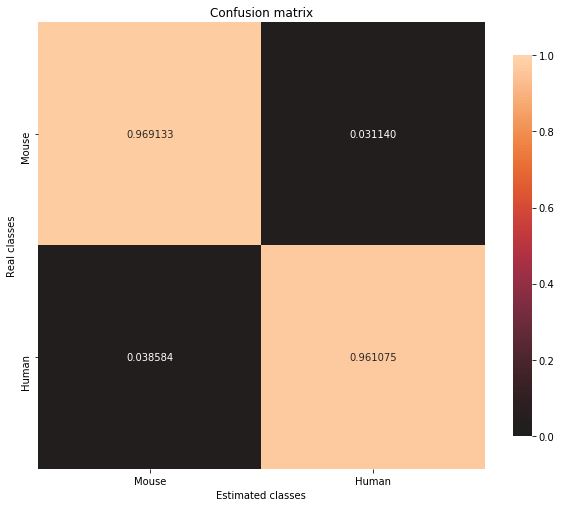

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10,10))
sns.heatmap(best_metrics[5], ax=ax, vmin=0, vmax=1, center=0, square=True, cbar_kws={"shrink": 0.7}, xticklabels=classes, yticklabels=classes, annot=True, fmt="f")
ax.set_title("Confusion matrix")
ax.set_xlabel('Estimated classes')
ax.set_ylabel('Real classes')
plt.show()

### Save the model

In [12]:
import json
from keras import backend as K
import shutil

export_path = "models/classification"

new_hist = {}
for key in list(history.history.keys()):
    if type(history.history[key]) == np.ndarray:
        new_hist[key] = history.history[key].tolist()
    elif type(history.history[key]) == list:
        if type(history.history[key][0]) == np.float64 or type(history.history[key][0]) == np.float32:
            new_hist[key] = list(map(float, history.history[key]))

with open('models/history.json', 'w') as file:
    json.dump(new_hist, file)

shutil.rmtree(export_path)
signature = tf.saved_model.signature_def_utils.predict_signature_def(                                                                        
    inputs={'input': model.input}, outputs={'ouput': model.output})                                                                         
                                                                                                                                             
builder = tf.saved_model.builder.SavedModelBuilder(export_path)                                                                    
builder.add_meta_graph_and_variables(                                                                                                        
    sess=K.get_session(),                                                                                                                    
    tags=[tf.saved_model.tag_constants.SERVING],                                                                                             
    signature_def_map={                                                                                                                      
        tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY:                                                                
            signature                                                                                                                        
    })                                                                                                                                       
builder.save()

normalization = {
    "mean": mean_values[1:].tolist(),
    "stdev": std_values[1:].tolist()
}

with open(export_path + '/normalization.json', 'w') as file:
    json.dump(normalization, file, indent=4)
    
shutil.make_archive(export_path, "zip", export_path)

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: models/classification\saved_model.pb


'D:\\Quentin Juppet\\Bureau\\Projet de semestre\\NucleiClassifier\\Python script\\classification\\models\\classification.zip'

### Analyse features importance

In [13]:
model_copy = get_model(False)

for i, layer in enumerate(model.layers[1:]):
    model_copy.layers[i].set_weights(layer.get_weights())

model_copy.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

In [14]:
import eli5
from eli5.permutation_importance import get_score_importances

nb_observation = 500
inputs_obs = inputs[:nb_observation,:].reshape((-1, target_size));
targets_obs = targets[:nb_observation,:]

def score(x, y):
    loss, accuracy = model_copy.evaluate(x, y, verbose=0)
    return accuracy

base_score, score_decreases = get_score_importances(score, inputs_obs, targets_obs, n_iter=10)
feature_importances = np.mean(score_decreases, axis=0)
feature_std = np.std(score_decreases, axis=0)

sort_index = np.argsort(feature_importances)[::-1]
print("Feature Importances:")
for i in range(target_size):
    j = sort_index[i]
    if(j < num_features):
        print(headers[j + 1] +":  "+ str(np.round(feature_importances[j],3)) + " +- " + str(np.round(feature_std[j],3)))

D:\Anaconda3\envs\ProjetSemestre\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
D:\Anaconda3\envs\ProjetSemestre\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


Feature Importances:
Mean cytoplasm variance value channel 1 up to 40 connected neighbours:  0.054 +- 0.009
Cytoplasm mean value channel 3:  0.027 +- 0.007
Mean cytoplasm sum of squares: variance up to 40 connected neighbours:  0.022 +- 0.004
Mean cytoplasm variance value channel 2 up to 40 connected neighbours:  0.015 +- 0.003
Mean cytoplasm correlation up to 40 connected neighbours:  0.014 +- 0.003
Mean nucleus variance value channel 3 up to 40 connected neighbours:  0.013 +- 0.005
Mean nucleus correlation up to 40 connected neighbours:  0.011 +- 0.002
Mean nucleus variance value channel 3 up to 20 connected neighbours:  0.009 +- 0.002
Variance cell elongation up to 40 connected neighbours:  0.008 +- 0.002
Mean cytoplasm correlation up to 20 connected neighbours:  0.008 +- 0.004
Nucleus variance value channel 1:  0.007 +- 0.002
Cytoplasm sum variance:  0.007 +- 0.003
Cytoplasm mean value channel 2:  0.007 +- 0.004
Mean cytoplasm variance value channel 1 up to 20 connected neighbours: